# Activity: Evaluating impacts from a 'Greener' Grid in Photovoltaic module production
Contribution by [Silvana Ovaitt](silvana.ovaitt@nrel.gov) & Justin Lian

This is a toy problem where we first select an activity (CdTe Photovoltaic Module Production), and change the Electricity Mix it is produced on assuming in a future it will be 'greener' with a simple assumption of al Coal produced electricity to change to be 'hydro'.

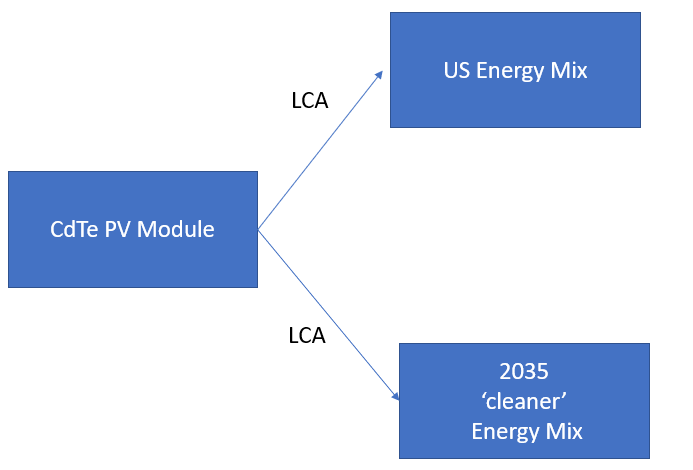


The steps:
<ol>
    <li><a href='#step1'> Load and copy the database </a></li>
    <li><a href='#step2'> Select the Activity "PV Module Production" </a></li>
    <li><a href='#step3'> Investigate which electricity mix processes are connected to the Activity  </a></li>
    <li><a href='#step4'> Change the electricity mix values in the database copy  </a></li>
    <li><a href='#step5'> Perform LCA calculation for impacts on the original and 'greener' electricity mixes  </a></li>
    


In [ ]:
import bw2io, bw2data
import brightway2 as bw

In [ ]:
import brightway2 as bw

In [ ]:
bw2io.restore_project_directory("/srv/data/projects/ecoinvent38.tar.gz")
bw2data.projects.set_current('ei38-teaching')

In [ ]:
bw.databases

<a id='step1'></a>

## 1. Load and copy the database 

First let's try to delete the fake database in case you have run this journal previuosly, to start from a fresh copy

In [ ]:
try:
    del bw.databases["hydro scenario"]
except:
    print("No hydro added yet :)")

Copying the database

In [ ]:
bw.Database("ei 3.8 cutoff").copy("hydro scenario")

In [ ]:
db_original = bw.Database('ei 3.8 cutoff')

In [ ]:
db = bw.Database('hydro scenario')
len(db)

<a id='step2'></a>

## 2. Select the Activity "PV Module Production"

The two options of PV modules production in EcoInvent for the US were CdTe, and aSi. The data is **very** outdated. Because aSi is no longer part of any market due to its terrible efficiency, and the US has almost 40% of PV market (because of First Solar production there), let's go with CdTe

In [ ]:
CdTe_original = [act for act in db_original if 'photovoltaic laminate production, CdTe' in act['name'] and 'US' in act['location']][0]
CdTe_origbinal

In [ ]:
CdTe = [act for act in db if 'photovoltaic laminate production, CdTe' in act['name'] and 'US' in act['location']][0]
CdTe

<a id='step3'></a>

## 3. Follow the rabbit hole: Investigate which electricity mix processes are connected to the Activity

We followed one by one the exchanges, and activities, until we found the Electricity mix to modify.
This is what we found:

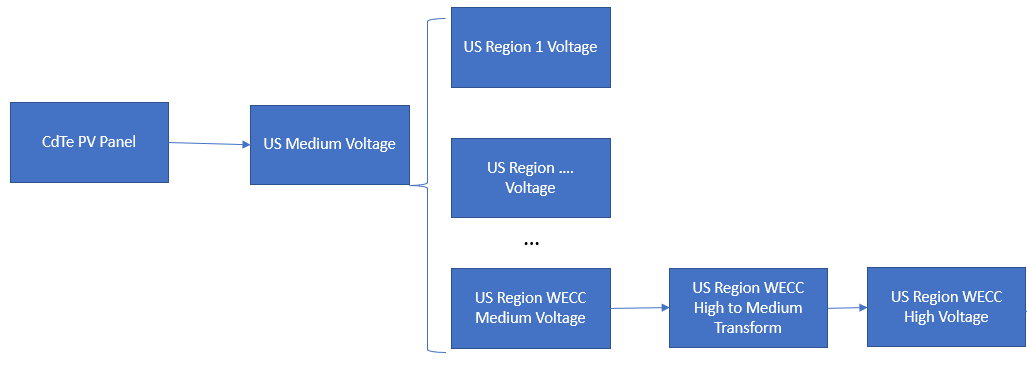

In [ ]:
[exc for exc in CdTe.technosphere() if 'electricity' in exc['name']]

In [ ]:
medMixGroup = [act for act in db if 'market group for electricity, medium voltage' in act['name'] and 'US' in act['location']][0]
medMixGroup

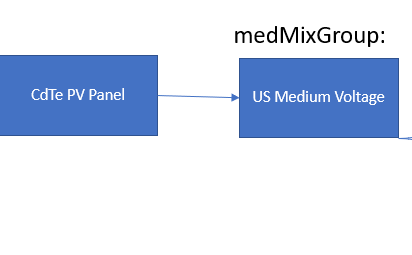

In [ ]:
[exc for exc in medMixGroup.technosphere() if 'electricity' in exc['name']]

There are many exchanges here from the variuos regions that contribute to this medium electricity mix Group. We are selecting the `US-WECC` to investigate (and modify) initially. 

In [ ]:
medMix = [act for act in db if 'market for electricity, medium voltage' in act['name'] and 'US-WECC' in act['location']][0]

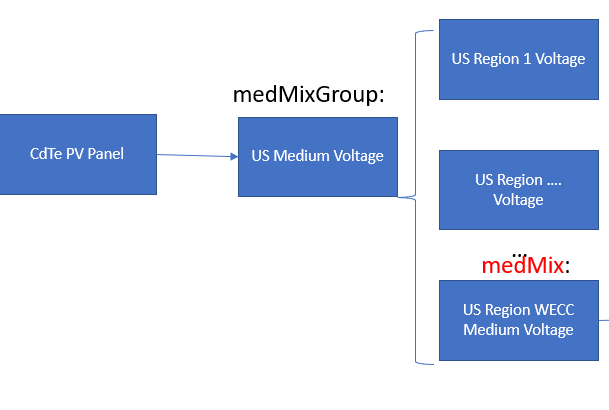

In [ ]:
[exc for exc in medMix.technosphere() if 'electricity' in exc['name']]

In [ ]:
hightrans = [act for act in db if 'electricity voltage transformation from high to medium voltage' in act['name'] and 'US-WECC' in act['location']][0]

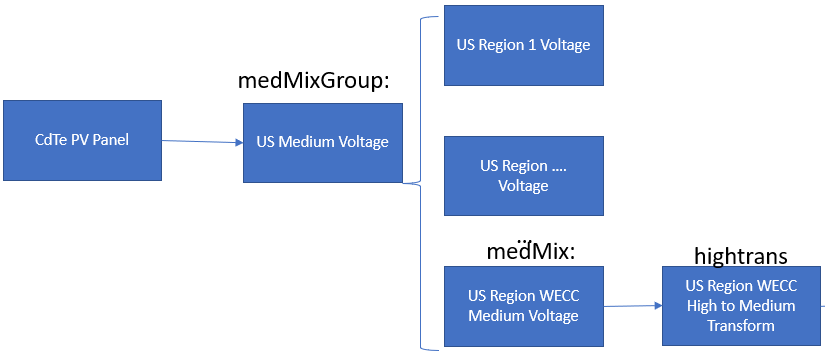

In [ ]:
[exc for exc in hightrans.technosphere() if 'electricity' in exc['name']][0]

In [ ]:
highvolt = [act for act in db if 'market for electricity, high voltage'  in act['name'] and 'US-WECC' in act['location']][0]
highvolt

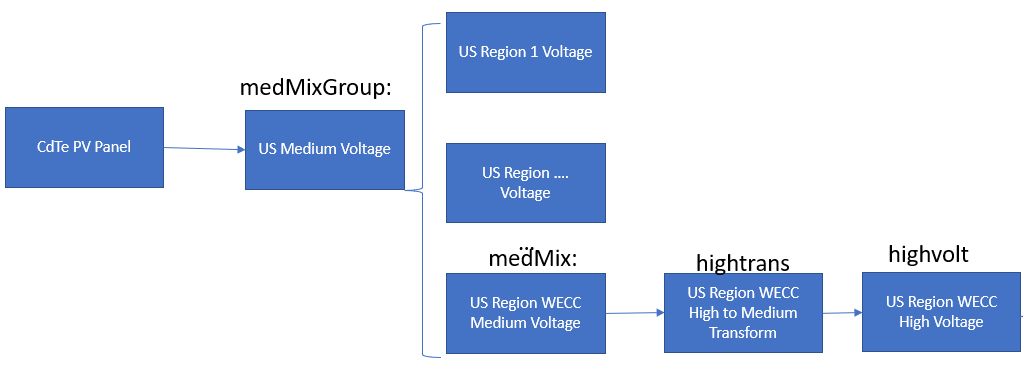

In [ ]:
[exc for exc in highvolt.technosphere()] 

We are finally at the rigth process that has the exchanges related to Coal, Hydro, Wind, PV, etc. Yay! Let's modify this one.

<a id='step4'></a>

## 4. Change the electricity mix values in the database copy 

In [ ]:
# Sanity check to see the total amount of technosphere exchanges before making the change
import numpy as np
np.sum([exc['amount'] for exc in highvolt.technosphere()])

Performing a very silly substitution where we change whatever was produced by coal into hydro. 
Not pretty or accurate but works for the purpose of this exercise. 

In [ ]:
foo = 0
for exc in highvolt.technosphere():
    provider = bw.get_activity(exc["input"])
    if "coal" in provider["name"]:
        foo = foo + exc['amount']
        exc['amount'] = 0
        exc.save()
        print(exc)

fixed = False
for exc in highvolt.technosphere():
    provider = bw.get_activity(exc["input"])
    if fixed == False:
        if "hydro" in provider["name"]:
            exc['amount'] = exc['amount'] + foo 
            exc.save()
            fixed = True

In [ ]:
# Sanity check to make sure the total amount of technosphere exchanges reduced 
np.sum([exc['amount'] for exc in highvolt.technosphere()])

<a id='step5'></a>

## 5. Perform LCA calculation for impacts on the original and 'greener' electricity mixes 

In [ ]:
myFirstLCA_quick = bw.LCA({CdTe_original:2}, ('IPCC 2013', 'climate change', 'GWP 100a'))
myFirstLCA_quick.lci()    # Builds matrices, solves the system, generates an LCI matrix.
myFirstLCA_quick.lcia()   # Characterization, i.e. the multiplication of the elements 
                          # of the LCI matrix with characterization factors from the chosen method
print(myFirstLCA_quick.score)    # Returns the score, i.e. the sum of the characterized inventory

myFirstLCA_quick2 = bw.LCA({CdTe:2}, ('IPCC 2013', 'climate change', 'GWP 100a'))
myFirstLCA_quick2.lci()    # Builds matrices, solves the system, generates an LCI matrix.
myFirstLCA_quick2.lcia()   # Characterization, i.e. the multiplication of the elements 
                          # of the LCI matrix with characterization factors from the chosen method
print(myFirstLCA_quick2.score)    # Returns the score, i.e. the sum of the characterized inventory

print("The amazing change from changing the grid of coal in Just that one region is ", myFirstLCA_quick-myFirstLCA_quick2 )


## 6. To DO: 

### Modify the grid for ALL regions that feed into the PV module manufacutring--not just the WECC-- and use REAL values of how the grid is supposed to be in a future year (i.e. 2035)